# 2. Run segmentation free methods

We want to perform segmentation-free methods in order to identify areas that locally resemble cell bodies and, thus, could be considered as intracellular. In this notebook we perform segmentation-free analysis with different algorithms (t.b.a)

## Import packages

In [3]:
import spatialdata as sd

import troutpy

## Read SpatialData dataset

We read the sdata cropped object we created in ``0.format_xenium_sdata.ipynb``

In [8]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/lib/python3.10/site-packages/zarr/creation.py:614: UserWarning: ignoring keyword argument 'read_only'
  compressor, fill_value = _kwargs_compat(compressor, fill_value, kwargs)
/home/sergio/.local/

### Run  segmentation-free (points2regions)

We use ``troutpy.tl.segmentation_free_clustering`` to perform segmentation-free clustering. Several segmentation-free algorithms are implemented within troutpy. In this case, we apply points2regions (Andersson et al. 2024) to define the main segmentation-free clusters 

In [9]:
# define points2regions_params
points2regions_params = {"num_clusters": 100, "pixel_width": 0.4, "pixel_smoothing": 3.5}
# run_segmentation_free
troutpy.tl.segmentation_free_clustering(sdata, params=points2regions_params, x="x", y="y", feature_name="feature_name", transcript_id="transcript_id")

/home/sergio/.local/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


Creating anndata


/home/sergio/.local/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


In [20]:
sdata.points["transcripts"]["x"]

Dask Series Structure:
npartitions=1
0          float32
5132695        ...
Name: x, dtype: float32
Dask Name: getitem, 27 graph layers

The output of segmentation-free clustering is stored in ``sdata.tables['segmentation_free_table']`` as an AnnData object. In this object, every observation corresponds to an analyzed transcript, which has a Cluster assigned.

In [13]:
sdata.tables["segmentation_free_table"]

AnnData object with n_obs × n_vars = 2114819 × 13035
    obs: 'Clusters'
    uns: 'reads'
    obsm: 'spatial'

## Define extracellular transcripts

Next, we will use the output of segmentation and segmentation-free analysis to define extracellular transcripts. For this, we will employ the command ``troutpy.pp.define_extracellular``. Essentially, extracellular transcripts will be defined as those:
- Located outside segmented cells
- Assigned to segmentation-free clusters that aren't mainly located inside segmented cells (thus, enriched outside)

In [21]:
troutpy.pp.define_extracellular(sdata, method="segmentation_free", min_prop_of_extracellular=0.8)

/home/sergio/.local/lib/python3.10/site-packages/spatialdata/_core/_elements.py:106: UserWarning: Key `transcripts` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


As an output, a new column `extracellular` is created in ``sdata.points['transcripts']``. All reads considered extracellulared are assigned to True in this column. Following analysis will employ this column to divide cellular and extracellular transcripts

In [22]:
sdata.points["transcripts"]["extracellular"]

Dask Series Structure:
npartitions=1
0          bool
5132695     ...
Name: extracellular, dtype: bool
Dask Name: getitem, 31 graph layers

## Write processed output

Finally we save the processed sdata object with defined extracellular transcripts as sdata

In [7]:
xenium_path_cropped = "/media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr"
sdata.write(xenium_path_cropped, overwrite=True)

INFO     The SpatialData object is not self-contained (i.e. it contains some elements that are Dask-backed from    
         locations outside /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr). Please see the
         documentation of `is_self_contained()` to understand the implications of working with SpatialData objects 
         that are not self-contained.                                                                              
INFO     The Zarr backing store has been changed from /media/sergio/Discovair_final/mousebrain_prime_crop.zarr the 
         new file path: /media/sergio/Discovair_final/mousebrain_prime_crop_points2regions.zarr                    


# Alternative segmentation free: sainsc

First we read the dataset

In [4]:
xenium_path_cropped = "/media/sergio/Meninges/troutpy/rois/xenium_hsprostate/data_processed.zarr"
sdata = sd.read_zarr(xenium_path_cropped)

An alternative approach is to use sainsc, which one can run using ``troutpy.pp.segmentation_free_sainsc``

In [17]:
from functools import partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import polars as pl
import spatialdata as sd
from sainsc import LazyKDE  # assuming LazyKDE is available
from scipy.sparse import coo_matrix
from sklearn.neighbors import KDTree


def process_gene(group, shape):
    """Process a group corresponding to one gene to build a sparse matrix."""
    gene_name = group["gene"][0]
    x = group["bin_x"].to_numpy()
    y = group["bin_y"].to_numpy()
    counts = group["count"].to_numpy()
    sparse_matrix = coo_matrix((counts, (x, y)), shape=shape).tocsr()
    return gene_name, sparse_matrix


def process_dataframe(df: pl.DataFrame, binsize: float, n_threads: int = 4):
    """Process a Polars DataFrame by binning spatial coordinates, converting the gene column to categorical, and constructing sparse matrices for each gene."""
    # Compute bin coordinates.
    df = df.with_columns((df["x"] / binsize).floor().alias("bin_x"), (df["y"] / binsize).floor().alias("bin_y"))
    # Shift coordinates so that bins start at zero.
    df = df.with_columns(
        (df["bin_x"] - df["bin_x"].min()).cast(pl.Int32).alias("bin_x"), (df["bin_y"] - df["bin_y"].min()).cast(pl.Int32).alias("bin_y")
    )
    # Ensure count column exists; if not, add one.
    if "count" not in df.columns:
        df = df.with_columns(pl.lit(1, dtype=pl.UInt32).alias("count"))
    else:
        df = df.with_columns(df["count"].cast(pl.UInt32))
    # Make gene column categorical.
    df = df.with_columns(df["gene"].cast(pl.Categorical))

    # Determine grid shape from binned coordinates.
    shape = (df["bin_x"].max() + 1, df["bin_y"].max() + 1)

    # Partition by gene for parallel processing.
    gene_groups = df.partition_by("gene", maintain_order=False)
    process_gene_partial = partial(process_gene, shape=shape)

    with Pool(n_threads) as pool:
        gene_results = pool.map(process_gene_partial, gene_groups)

    results = {}
    for gene, matrix in gene_results:
        results[gene] = matrix

    return results, shape, df


def segmentation_free_sainsc(
    sdata,
    binsize=3,
    celltype_key="leiden",
    background_filter=0.4,
    gaussian_kernel_key=2.5,
    n_threads=16,
    resolution=1000,
    codeword_category="predesigned_gene",
    return_sainsc=False,
    copy=False,
    # Defaults for missing bin info
    default_cell_type="unknown",
    default_numeric=np.nan,
):
    """
    Process an sdata object by running an integrated sainsc analysis pipeline with configurable parameters.

    Steps:
      1. Extract and filter transcript data.
      2. Compute cell type signatures.
      3. For KDE/cell type assignment, use only transcripts with overlapping genes.
      4. Bin all transcripts.
      5. Merge the bin-level metadata (computed from successful bins) back to the full transcript set.
      6. For transcripts that do NOT obtain metadata via the merge, assign them the data
         from their spatially closest neighbor (based on "x", "y").
    """
    # --- 1. Prepare Transcript Data ---
    transcripts_all = sdata.points["transcripts"][["gene", "x", "y", "transcript_id"]].compute().reset_index(drop=True)
    # transcripts_all = transcripts_all[transcripts_all["codeword_category"] == codeword_category]
    transcripts_all = transcripts_all[transcripts_all["gene"].astype(str) != "nan"]

    # Create a full DataFrame for binning (all transcripts are retained)
    transcripts_full = pl.from_pandas(transcripts_all[["gene", "x", "y"]].copy(), schema_overrides={"gene": pl.Categorical})

    # --- 2. Retrieve Cell Expression Data & Compute Signatures ---
    adata = sdata["table"]
    expr = adata.to_df()
    expr["cell type"] = adata.obs[celltype_key]
    signatures = expr.groupby("cell type").mean().transpose()

    # --- 3. Determine Overlapping Genes for Analysis ---
    common_genes = set(transcripts_all["gene"].unique()).intersection(set(signatures.index))
    transcripts_analysis = transcripts_full.filter(pl.col("gene").is_in(list(common_genes)))

    # Filter the signature matrix to match KDE
    signatures = signatures.loc[signatures.index.isin(common_genes), :]
    #
    # --- 4. Create Brain Object Using LazyKDE (Analysis on overlapping genes) ---
    brain = LazyKDE.from_dataframe(transcripts_analysis, resolution=resolution, binsize=binsize, n_threads=n_threads)

    # --- 5. Process All Transcripts into Binned Data ---
    _, shape, transcript2bin_info = process_dataframe(transcripts_full, binsize=binsize, n_threads=n_threads)
    transcript2bin_info = transcript2bin_info.to_pandas()
    transcript2bin_info["bin_x_y_id"] = transcript2bin_info["bin_x"].astype(str) + "_" + transcript2bin_info["bin_y"].astype(str)

    # --- 6. Prepare Unique Identifiers for Merging ---
    # Round coordinates to create matching keys.
    transcripts_all["x"] = transcripts_all["x"].round(4)
    transcripts_all["y"] = transcripts_all["y"].round(4)
    transcript2bin_info["x"] = transcript2bin_info["x"].round(4)
    transcript2bin_info["y"] = transcript2bin_info["y"].round(4)
    transcripts_all["xy"] = transcripts_all["x"].astype(str) + "_" + transcripts_all["y"].astype(str)
    transcript2bin_info["xy"] = transcript2bin_info["x"].astype(str) + "_" + transcript2bin_info["y"].astype(str)

    # --- 7. Run KDE, Background Filtering and Cell Type Assignment ---
    brain.calculate_total_mRNA()
    brain.gaussian_kernel(gaussian_kernel_key, unit="um")
    brain.calculate_total_mRNA_KDE()
    brain.filter_background(background_filter)
    brain.assign_celltype(signatures, log=True)

    # --- 8. Compute Bin-level Features from Brain ---
    celltype_flat = brain.celltype_map.flatten()
    assignment_score_flat = brain.assignment_score.flatten()
    cosine_similarity_flat = brain.cosine_similarity.flatten()

    n_rows, n_cols = brain.celltype_map.shape
    x_coords, y_coords = np.meshgrid(np.arange(n_cols), np.arange(n_rows))
    x_coords = x_coords.flatten()
    y_coords = y_coords.flatten()

    output_df = pd.DataFrame(
        {
            "bin_x": x_coords,
            "bin_y": y_coords,
            "cell type": celltype_flat,
            "assignment_score": assignment_score_flat,
            "cosine_similarity": cosine_similarity_flat,
        }
    )
    num2ct = dict(zip(range(len(brain.celltypes)), brain.celltypes, strict=False))
    output_df["cell type"] = output_df["cell type"].map(num2ct)
    output_df["bin_x_y_id"] = output_df["bin_y"].astype(str) + "_" + output_df["bin_x"].astype(str)

    # Build mapping dictionaries.
    bin2celltype = dict(zip(output_df["bin_x_y_id"], output_df["cell type"], strict=False))
    bin2cosine = dict(zip(output_df["bin_x_y_id"], list(output_df["cosine_similarity"]), strict=False))
    bin2assign = dict(zip(output_df["bin_x_y_id"], list(output_df["assignment_score"]), strict=False))

    # --- 9. Merge Bin-level Features for Transcripts That Were Successfully Binned ---
    # Merge on the unique "xy" identifier.
    bin_features = transcript2bin_info[["xy", "bin_x_y_id"]].drop_duplicates()
    bin_features["closest_cell_type"] = bin_features["bin_x_y_id"].map(bin2celltype)
    bin_features["cosine_similarity"] = bin_features["bin_x_y_id"].map(bin2cosine)
    bin_features["assignment_score"] = bin_features["bin_x_y_id"].map(bin2assign)

    # Perform a left merge so all transcripts are retained.
    merged = pd.merge(transcripts_all, bin_features, on="xy", how="left")

    # --- 10. Apply Nearest-Neighbor Assignment Only When Merge Failed ---
    missing_mask = merged["closest_cell_type"].isna()
    if missing_mask.sum() > 0:
        # Use only transcripts that have valid bin metadata.
        valid = merged[~missing_mask]
        missing = merged[missing_mask]
        if not valid.empty:
            # Build KDTree using the positions (x,y) of valid transcripts.
            tree = KDTree(valid[["x", "y"]].values)
            distances, indices = tree.query(missing[["x", "y"]].values, k=1)
            nn_metadata = valid.iloc[indices.flatten()].reset_index(drop=True)
            for col in ["closest_cell_type", "cosine_similarity", "assignment_score"]:
                missing[col] = nn_metadata[col].values
            merged.loc[missing_mask, ["closest_cell_type", "cosine_similarity", "assignment_score", "match_cell_signature"]] = missing[
                ["closest_cell_type", "cosine_similarity", "assignment_score"]
            ]

    # --- 11. Fill Any Remaining Missing Values with Defaults ---
    merged["closest_cell_type"] = merged["closest_cell_type"].fillna(default_cell_type)
    merged["cosine_similarity"] = merged["cosine_similarity"].fillna(default_numeric)
    merged["assignment_score"] = merged["assignment_score"].fillna(default_numeric)

    # Optionlly, force the correct data types
    merged["closest_cell_type"] = merged["closest_cell_type"].astype(str)
    merged["cosine_similarity"] = merged["cosine_similarity"].astype(float)
    merged["assignment_score"] = merged["assignment_score"].astype(float)

    # --- 12. Update the sdata Object ---
    transi = sdata.points["transcripts"].compute().copy()
    transi["xy"] = transi["x"].round(4).astype(str) + "_" + transi["y"].round(4).astype(str)
    # Drop duplicated columns if needed
    columns_to_remove = ["closest_cell_type", "cosine_similarity", "assignment_score"]
    cols_to_drop = [col for col in columns_to_remove if col in transi.columns]
    transi = transi.drop(columns=cols_to_drop)

    # Then merge safely
    transi = pd.merge(
        transi,
        merged[["xy", "closest_cell_type", "cosine_similarity", "assignment_score"]],
        on="xy",
        how="left",
    )
    # Fill any remaining missing entries as a safeguard (should be none now)
    transi["closest_cell_type"] = transi["closest_cell_type"].fillna(default_cell_type).astype(str)
    transi["cosine_similarity"] = transi["cosine_similarity"].fillna(default_numeric).astype(float)
    transi["assignment_score"] = transi["assignment_score"].fillna(default_numeric).astype(float)
    # Update the transcripts layer
    sdata.points["transcripts"] = sd.models.PointsModel.parse(transi)

    # --- 13. Return Results ---
    sainsc_output = {"brain": brain, "transcript2bin_info": transcript2bin_info, "output_df": output_df}
    if return_sainsc:
        return sdata, sainsc_output
    else:
        return sdata if copy else None

In [18]:
segmentation_free_sainsc(sdata, binsize=3, celltype_key="leiden", background_filter=0.4, gaussian_kernel_key=2.5, n_threads=16)

Next, we will use the output of segmentation and segmentation-free analysis to define extracellular transcripts. For this, we will employ the command ``troutpy.pp.define_extracellular``. Essentially, extracellular transcripts will be defined as those:
- Located outside segmented cells
- With a cosine similarity to any cellular signature lower than the x percentile_threshold of transcripts located inside the cell (defined in sainsc). Higher values will be considered cell-like transcripts

In [21]:
trans = sdata["transcripts"].compute()

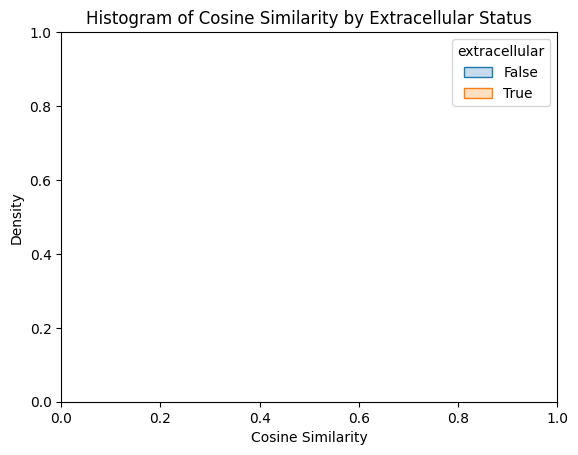

0


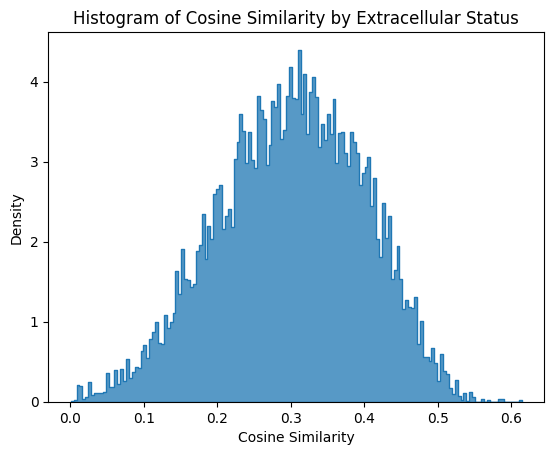

1


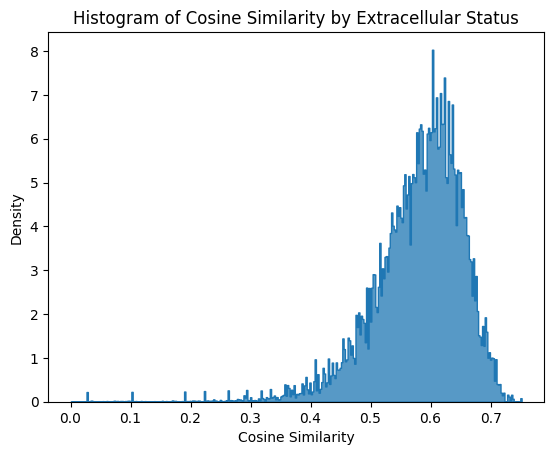

2


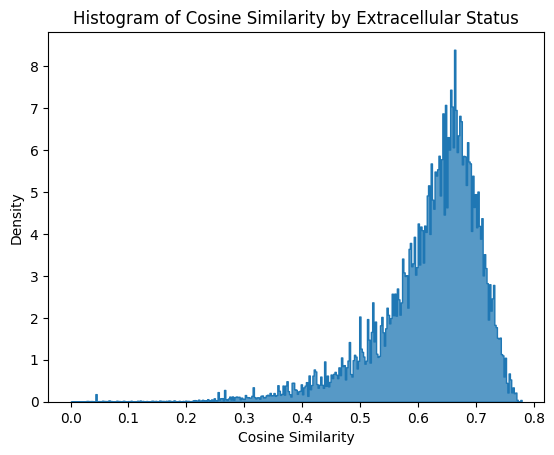

3


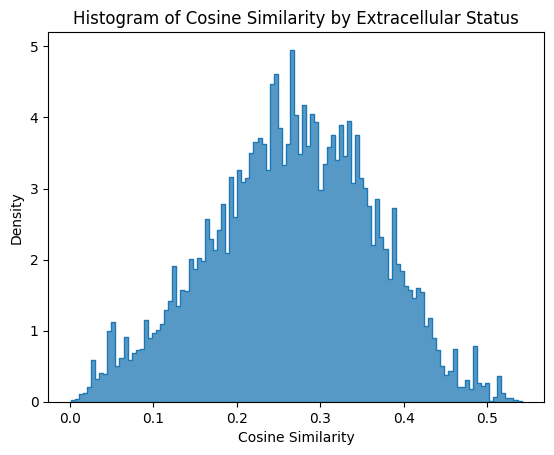

4


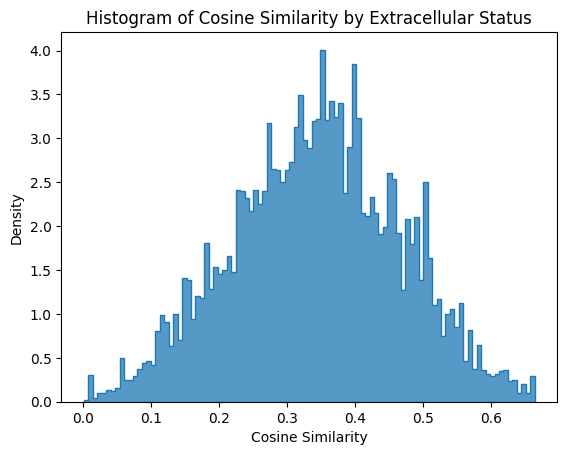

5


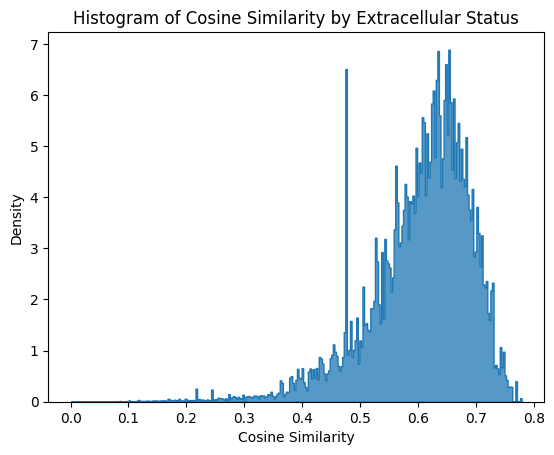

6


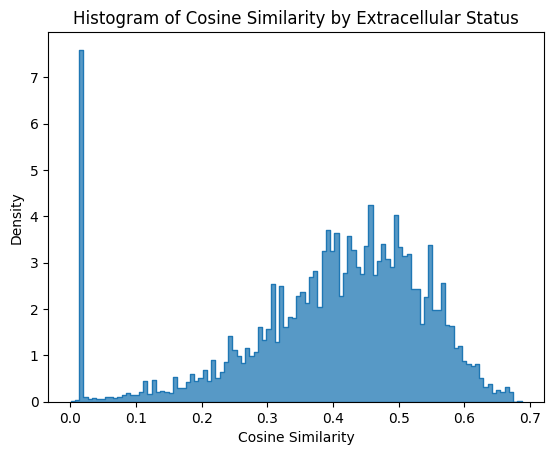

7


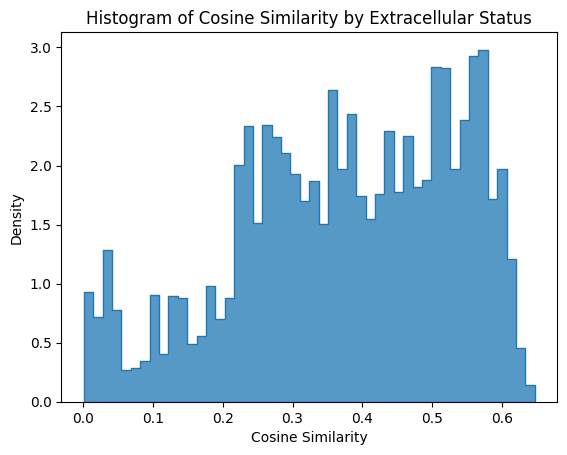

unknown


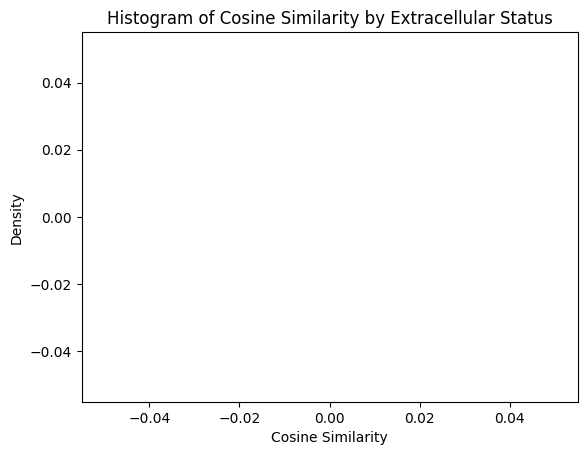

In [31]:
for c, i in trans.groupby("closest_cell_type"):
    print(c)
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Assuming `i` is your DataFrame
    sns.histplot(data=i, x="cosine_similarity", element="step", stat="density", common_norm=False)
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.title("Histogram of Cosine Similarity by Extracellular Status")
    plt.show()

In [8]:
troutpy.pp.define_extracellular(sdata, layer="transcripts", method="sainsc", unassigned_tag="UNASSIGNED", copy=False, percentile_threshold=2)

Cosine similarity threshold for extracellular definition: 0.21134984493255615


# Results visualization

In [1]:
troutpy.pl.pie(sdata, groupby="extracellular", group_key="overlaps_cell")

NameError: name 'troutpy' is not defined

<Figure size 500x500 with 0 Axes>

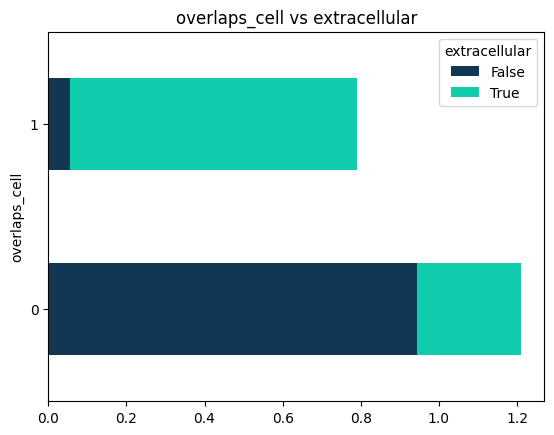

In [ ]:
troutpy.pl.crosstab(sdata, yvar="extracellular", xvar="overlaps_cell", normalize=True, cmap="troutpy", kind="barh", stacked=True)

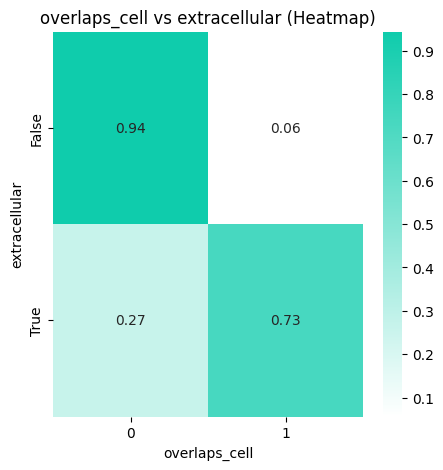

In [ ]:
troutpy.pl.crosstab(sdata, yvar="extracellular", xvar="overlaps_cell", normalize=True, cmap="Aquas", kind="heatmap", stacked=True)